# Example of Lonboard with GEDI L4A

[Lonboard](https://developmentseed.org/lonboard) is a new Python library for fast, interactive geospatial vector data visualization in Jupyter. By utilizing new technologies like [GeoArrow](https://github.com/geoarrow/geoarrow) and [GeoParquet](https://github.com/opengeospatial/geoparquet) in conjunction with [GPU-based map rendering](https://deck.gl/), lonboard aims to enable visualizing large geospatial datasets interactively through a simple interface.

## Install Required Python Packages

[`lonboard`](https://github.com/developmentseed/lonboard) is a required dependency of this notebook, as its goal is to show that for data visualization. Install with

```
pip install lonboard pyogrio
```

Then **reload your browser tab** to ensure that the JavaScript parts of lonboard are correctly loaded onto the page.

In [1]:
# !pip install lonboard pyogrio

This notebook will use existing output from a previous run of the GEDI subsetter, loading shared data from a shared bucket `dschuck`:

In [2]:
path = "/projects/shared-buckets/dschuck/gedi-subset-examples/GNQ-L4A-subset2.gpkg"

### Imports


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lonboard import ScatterplotLayer, Map
from lonboard.colormap import apply_continuous_cmap

### Loading the data

We'll use GeoPandas to load the data into a GeoDataFrame:

In [4]:
gedi_gdf = gpd.read_file(path, engine="pyogrio")

### Getting data on a map

Since this is a point dataset, we can plot it with a `ScatterplotLayer`:

In [5]:
layer = ScatterplotLayer.from_geopandas(gedi_gdf)
m = Map(layers=[layer])

Now just "display" the `Map` object by leaving it last in a cell, and a map should render with the data.

In [6]:
m

Map(layers=[ScatterplotLayer(table=pyarrow.Table
BEAM: string
agbd: float
agbd_se: float
sensitivity_a2: float…

The default styling of the points is just black, but we can change to another constant color by setting `get_fill_color` to an array of RGB colors:

In [7]:
layer.get_fill_color = [200, 100, 100]

After running the previous cell, you should see the map update the color of points to a reddish brown color.

In this case, we'd really like to plot data _based on a statistic_. Let's plot based on the value of the `agbd` column. We'll use a linear colormap excluding the lowest and highest 10 percentiles of the data.

First, we'll find what the values of the 10th and 90th percentile are:

In [8]:
q10 = gedi_gdf['agbd'].quantile(.1)
q90 = gedi_gdf['agbd'].quantile(.9)

Then we can construct a "normalizer" based on [`Normalize`](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Normalize.html) that will do linear rescaling between the two values we supply:

In [9]:
normalizer = mpl.colors.Normalize(q10, q90)

Calling this `normalizer` on our data will return a scaled version ranging between 0 and 1:

In [10]:
normalized_agbd = normalizer(gedi_gdf['agbd'])
normalized_agbd

masked_array(data=[ 0.42096179, -0.05778629,  0.19115537, ...,
                    0.19018107, -0.08210574, -0.08331736],
             mask=False,
       fill_value=1e+20)

We can now construct color values by taking a Matplotlib colormap and calling it on our normalized values. Ensure you use `bytes=True` when calling the colormap object so that the output colors range from 0-255 and not 0-1.

In [11]:
viridis_colormap = plt.cm.get_cmap("viridis_r")
layer.get_fill_color = viridis_colormap(normalized_agbd, bytes=True)
layer.radius_min_pixels = 1

/tmp/ipykernel_601/1041745806.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_colormap = plt.cm.get_cmap("viridis_r")


The map should now have updated to show points colored by their `agbd` value. To remind ourselves what the high and low values are, we can inspect the colormap object itself:

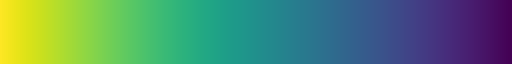

In [12]:
viridis_colormap

For information on styling options for the map, consult the [ScatterplotLayer documentation](https://developmentseed.org/lonboard/latest/api/layers/scatterplot-layer/).